In [ ]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q

In [3]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

In [4]:
# download dataset
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yamannagesachith
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification


100%|██████████| 217M/217M [00:01<00:00, 212MB/s]


In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)


train_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/test"

train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [6]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [7]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


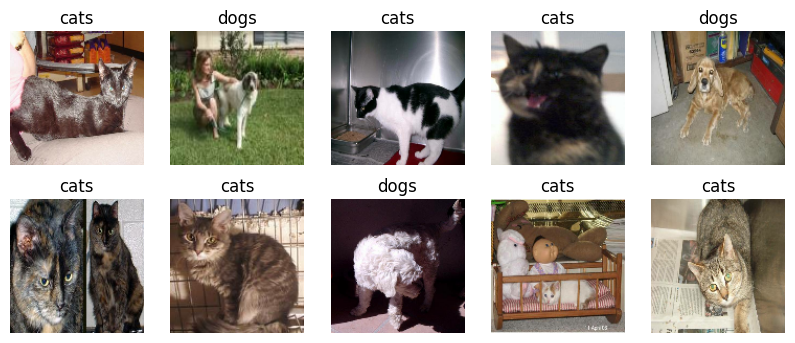

In [8]:
# plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [9]:
#Scaling Images

for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[101.00769   104.00769   109.00769  ]
   [111.074585  112.71521   114.30505  ]
   [117.635284  115.31354   112.59396  ]
   ...
   [129.86246   132.91324   136.22964  ]
   [126.8725    133.10297   135.69281  ]
   [128.9002    138.99207   139.94614  ]]

  [[ 85.20029    88.20029    93.20029  ]
   [ 99.3725     99.79227   101.78906  ]
   [114.00287   112.997925  110.048706 ]
   ...
   [116.720825  120.720825  123.720825 ]
   [119.9389    126.16937   128.75922  ]
   [138.79547   147.0824    148.93893  ]]

  [[ 92.54297    94.90234    99.58203  ]
   [ 91.57605    91.986206   93.986206 ]
   [105.38388   104.38388   101.75107  ]
   ...
   [120.73743   125.52237   128.52237  ]
   [130.21445   135.21445   138.21445  ]
   [127.32648   134.36554   136.68585  ]]

  ...

  [[118.07504   122.07504   125.07504  ]
   [121.617584  125.617584  128.61758  ]
   [130.54602   134.54602   137.54602  ]
   ...
   [ 81.51825    87.02301    96.76108  ]
   [ 45.951294   50.819916   54.147003 ]
   [ 

In [10]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))


In [12]:
#Data Augmentation

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

In [13]:

#Model Building

model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)      

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [15]:
#Model Training

start_time = time.time()

history = model.fit(train_data,
                    epochs=20,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/20
225/225 [==============================] - 18s 41ms/step - loss: 0.6820 - accuracy: 0.5754 - val_loss: 0.6733 - val_accuracy: 0.6025
Epoch 2/20
225/225 [==============================] - 10s 42ms/step - loss: 0.6484 - accuracy: 0.6147 - val_loss: 0.6432 - val_accuracy: 0.6225
Epoch 3/20
225/225 [==============================] - 9s 40ms/step - loss: 0.6357 - accuracy: 0.6329 - val_loss: 0.7293 - val_accuracy: 0.5800
Epoch 4/20
225/225 [==============================] - 13s 55ms/step - loss: 0.6244 - accuracy: 0.6496 - val_loss: 0.5886 - val_accuracy: 0.6938
Epoch 5/20
225/225 [==============================] - 11s 47ms/step - loss: 0.6013 - accuracy: 0.6724 - val_loss: 0.6353 - val_accuracy: 0.6525
Epoch 6/20
225/225 [==============================] - 9s 37ms/step - loss: 0.5764 - accuracy: 0.6919 - val_loss: 0.6438 - val_accuracy: 0.6587
Epoch 7/20
225/225 [==============================] - 9s 40ms/step - loss: 0.5613 - accuracy: 0.7060 - val_loss: 0.5390 - val_accuracy: 0.

In [16]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')


Total time for training 246.214 seconds


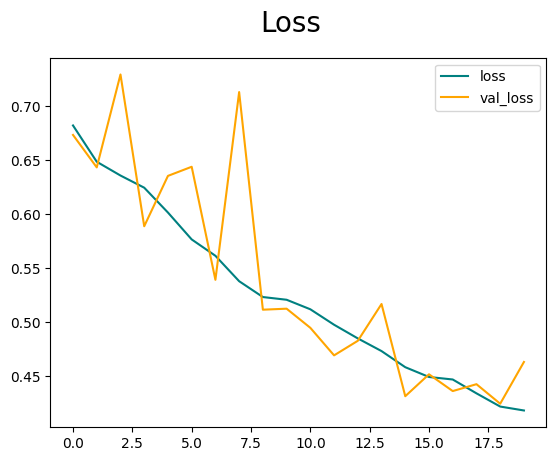

In [17]:
#Performance Analysis

fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()


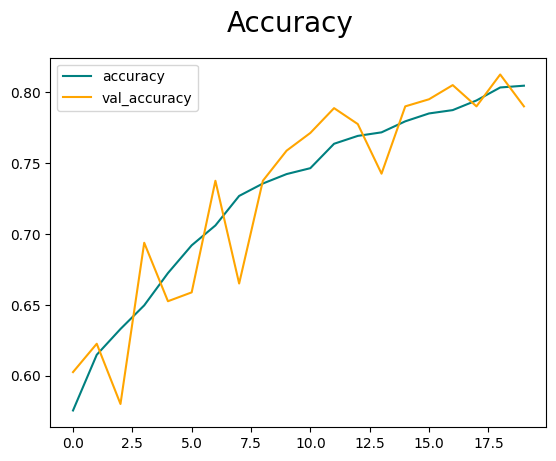

In [18]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

In [19]:
#Model Evaluation

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()


for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 357ms/step


In [20]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.73978317>

In [21]:
recall.result()


<tf.Tensor: shape=(), dtype=float32, numpy=0.887>

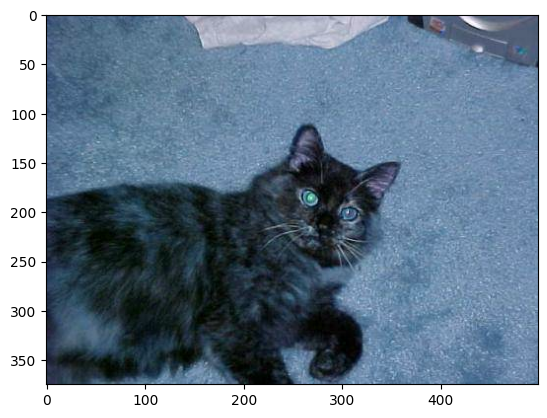

In [23]:
#Test

!pip install opencv-python -q



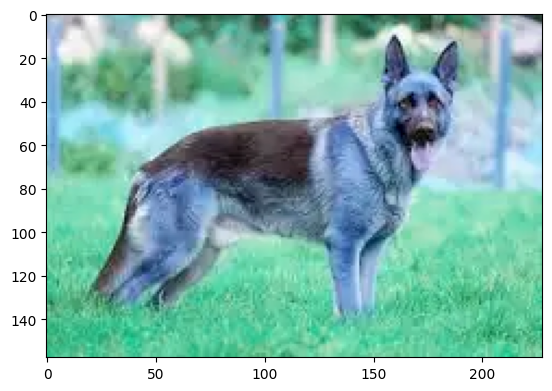

In [32]:

import cv2


img = cv2.imread('/content/drive/MyDrive/Deep learning/Image classifier/download.webp')
plt.imshow(img)
plt.show()


In [34]:


resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255

In [35]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

In [36]:
yhat = model.predict(np.expand_dims(scaled_image, 0))


1/1 [==============================] - 0s 20ms/step


In [37]:
yhat

array([[0.9702838]], dtype=float32)

In [38]:
if yhat > 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')

dogs
